I. Set Up

In [48]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from pre_ml_functions import *

# Specify global path
global_path = '/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('All', 'Bona'), value='Bona')

II. Data Preparation

In [2]:
# Set ID
set_id = set_widget.value
# Create region filtered files 
region_filter_fun(global_path,set_id)
# Create eventfile table
create_eventfilestable_fun(global_path,set_id)
# Combine all property tables with each other
dfp_list =[]
for prop_filename in glob.iglob(f'{global_path}/{set_id}/properties-{set_id}-*.csv'):
   dfp = pd.read_csv(prop_filename)
   dfp_list.append(dfp)
df_properties = pd.concat(dfp_list)
df_properties.to_csv(f'{global_path}/{set_id}/properties-{set_id}.csv',index=False)

# Reduce data for useful input to data representation
df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
df_properties = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_eventfiles_input, df_properties_input = data_reduction_fun(df_eventfiles, df_properties,global_path,set_id)



/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf14927_000N021_e2_r0312_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf13833_000N021_e2_r0384_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf00310_000N021_r0293_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf12160_001N021_e2_r0384_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf08193_000N021_e2_r0398_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/B

III. Show Bona-fide Examples

In [4]:
from matplotlib.colors import LogNorm
from sherpa.astro import ui

df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')

df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')

print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)

print("ObsID and RegID: ", df_eventfiles_group.groups.keys())

Number of Eventfiles:  17
Number of Property Sets:  17
ObsID and RegID:  dict_keys(['10822_185', '10921_3', '10969_216', '10995_21', '10996_27', '10996_5', '11013_34', '11104_129', '13682_9', '13814_176', '13814_567', '14436_54', '14538_5', '2833_53', '2896_129', '9109_333', '9109_344'])


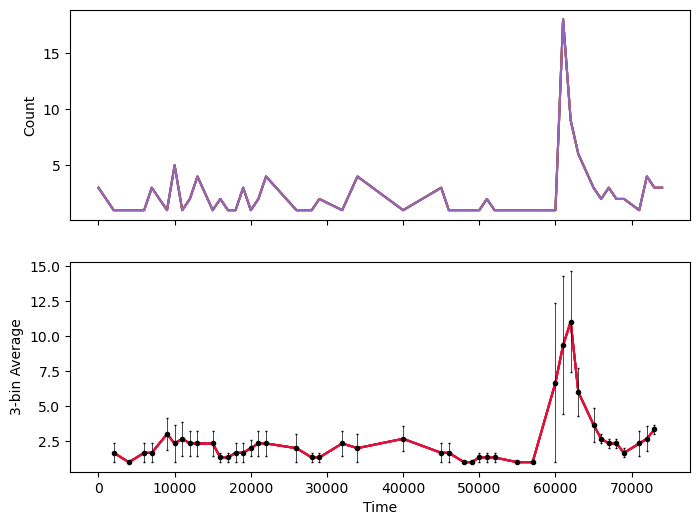

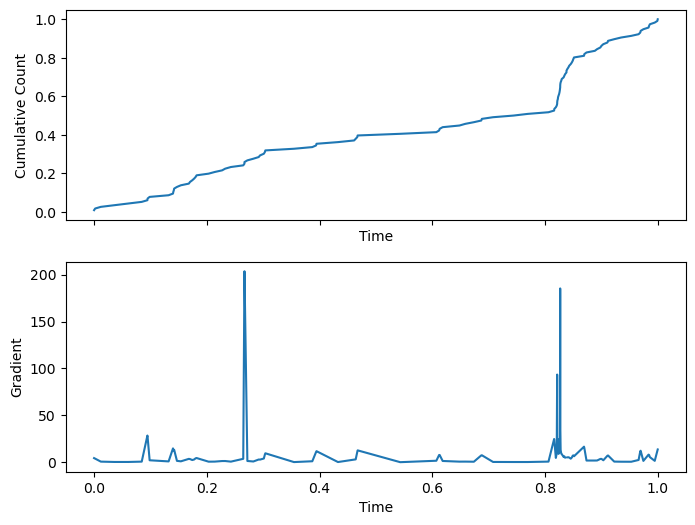

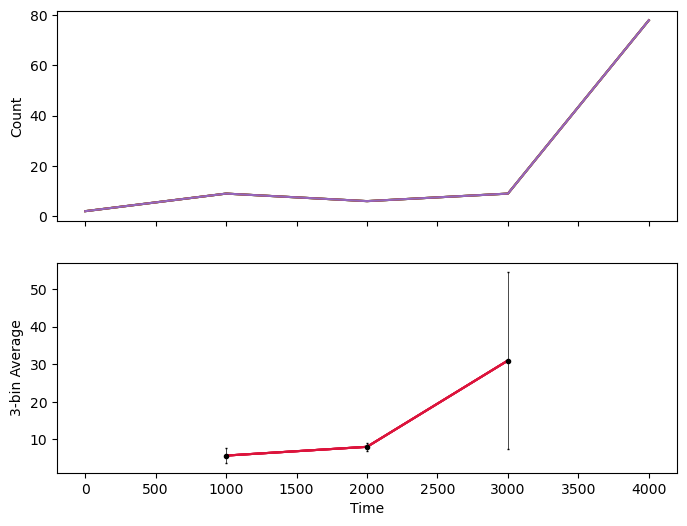

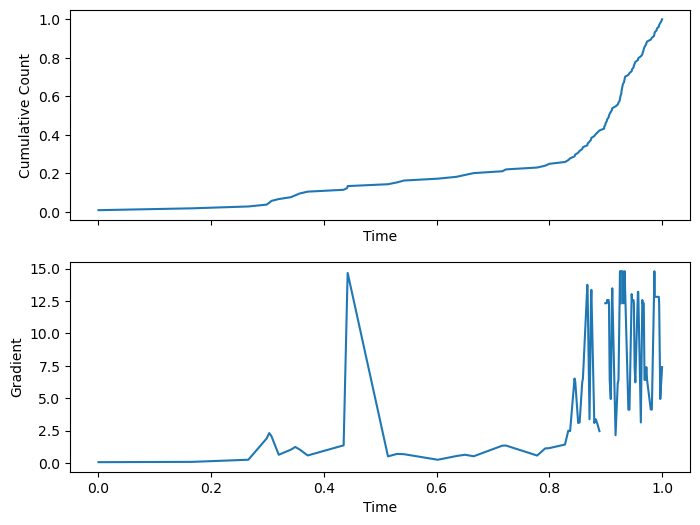

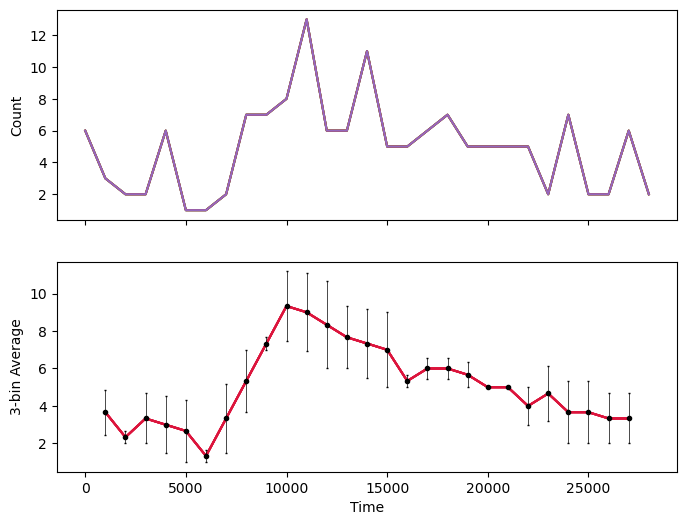

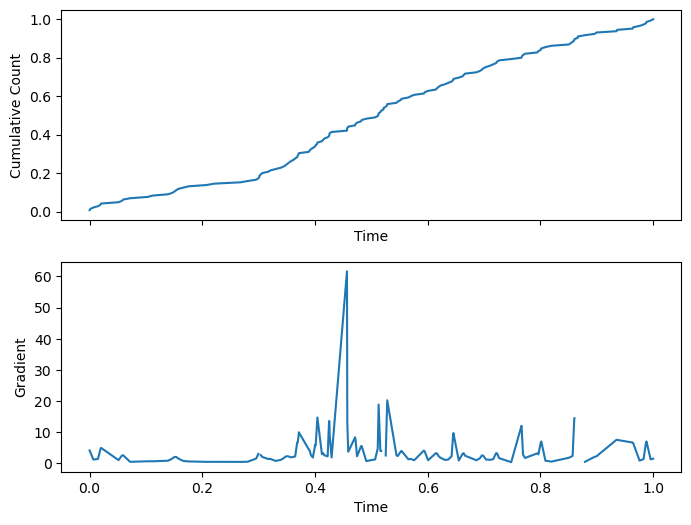

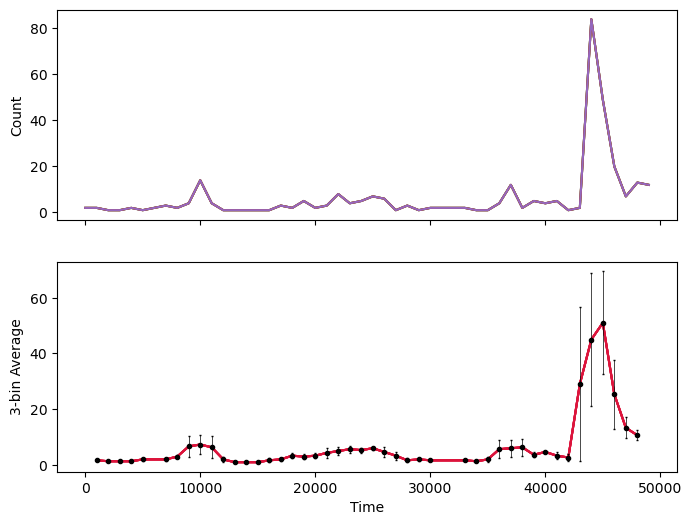

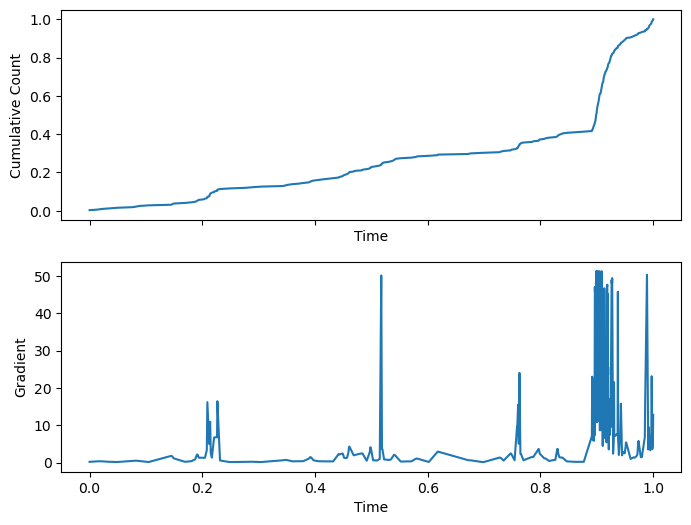

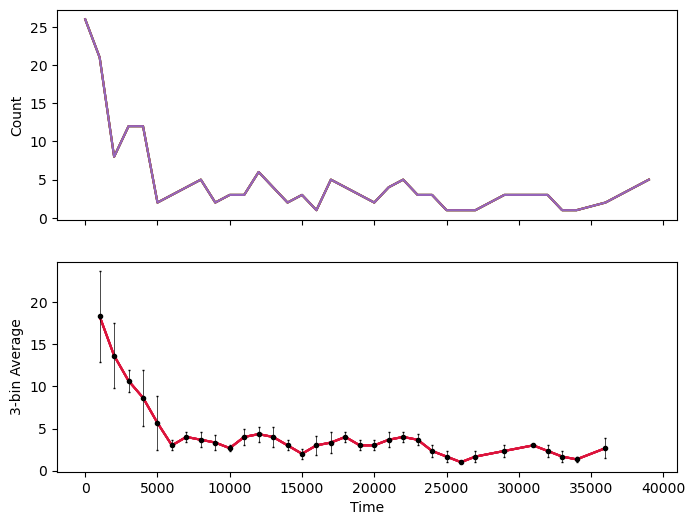

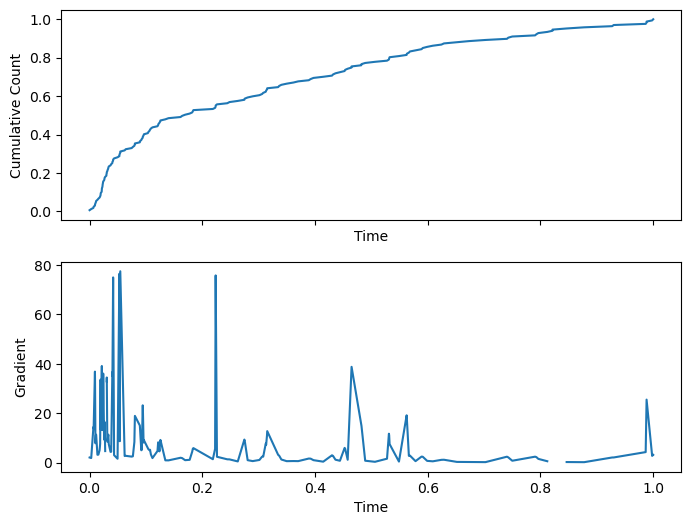

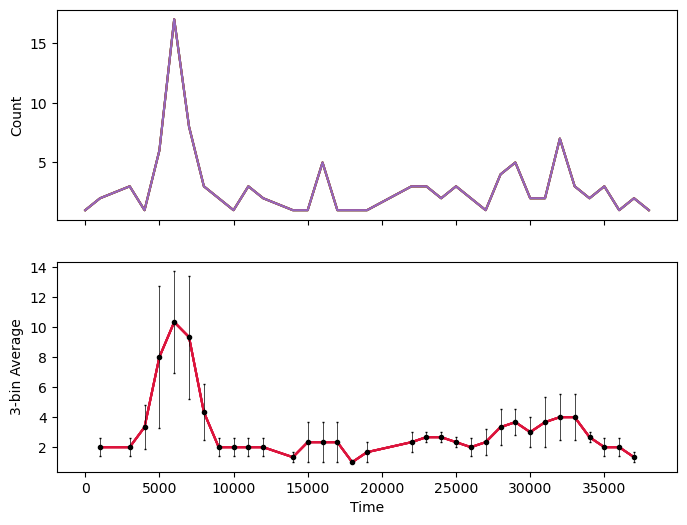

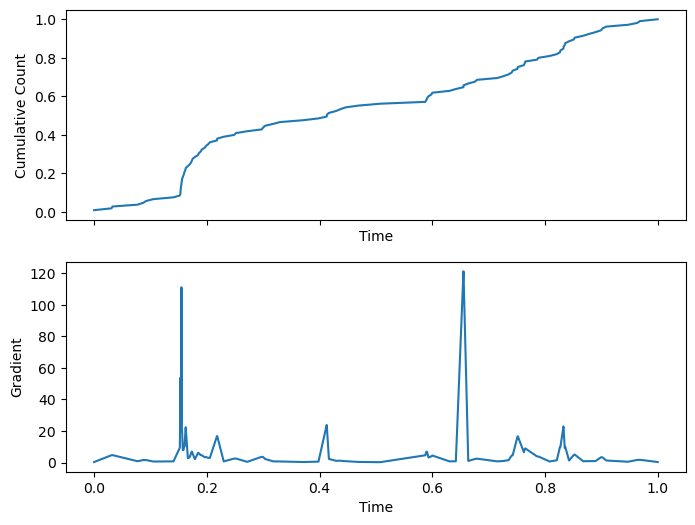

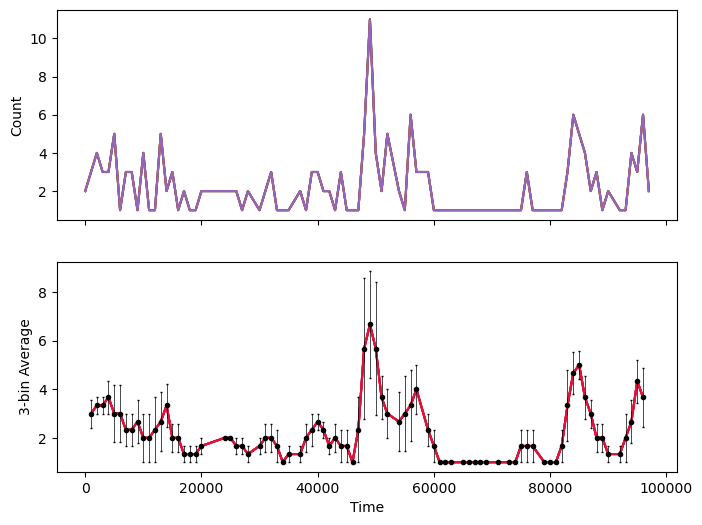

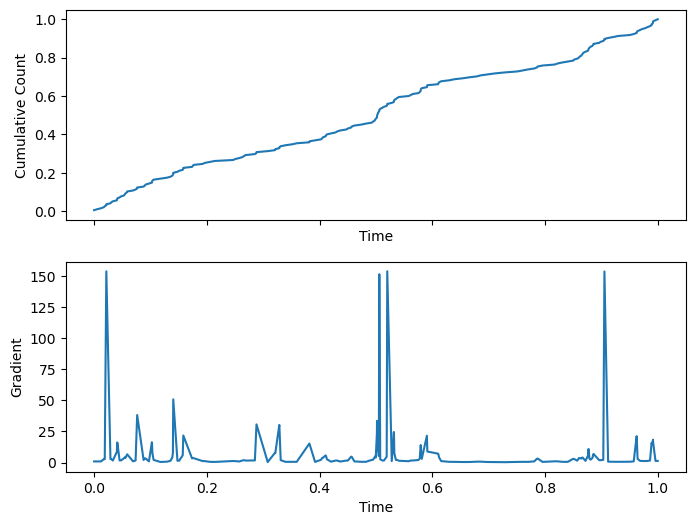

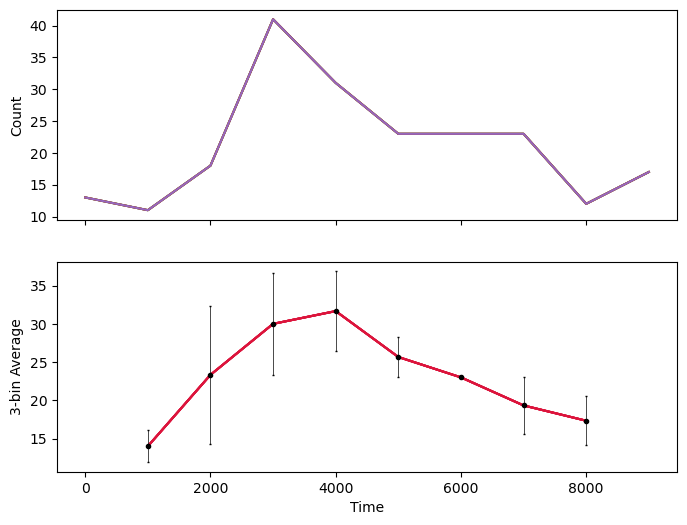

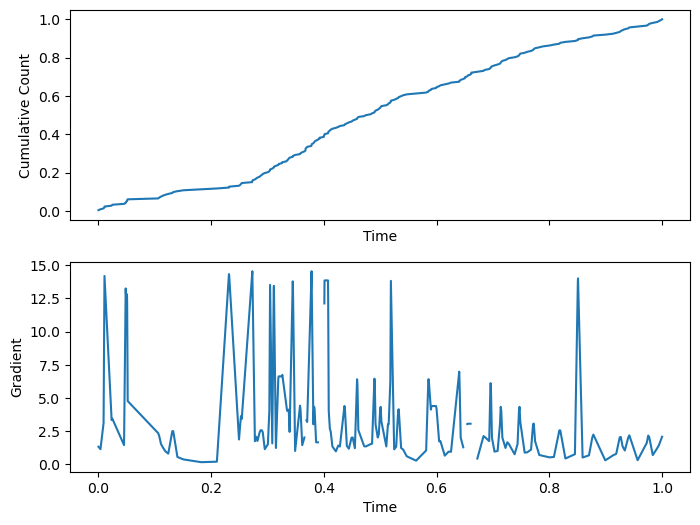

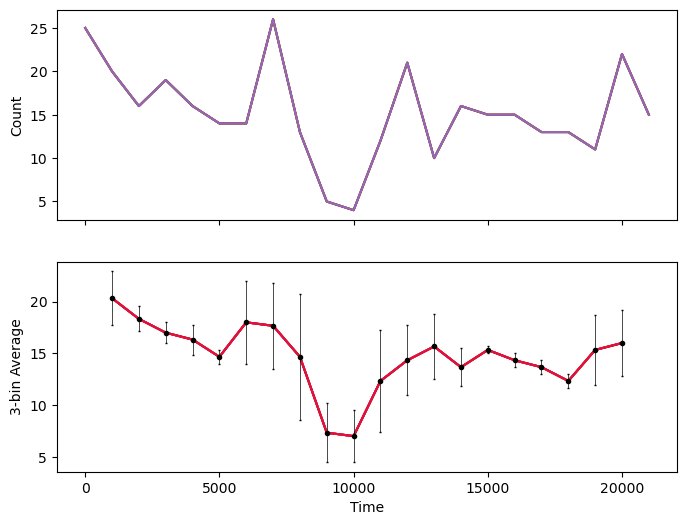

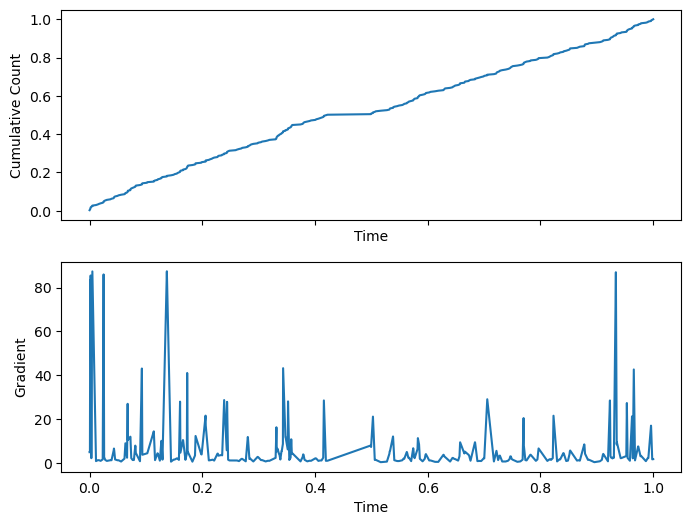

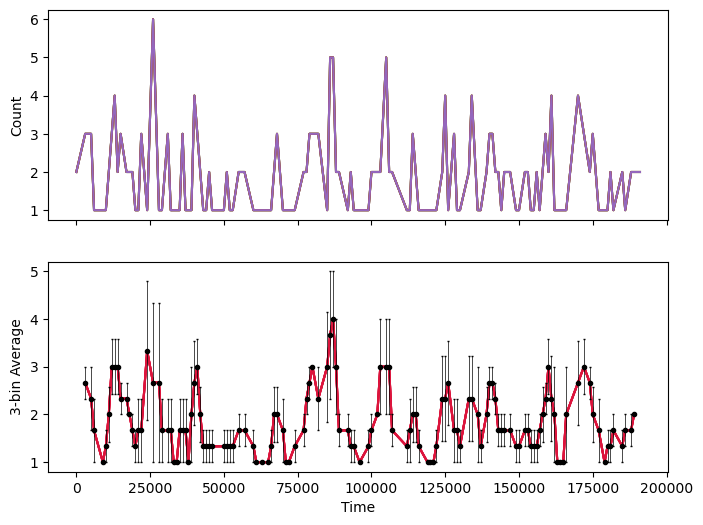

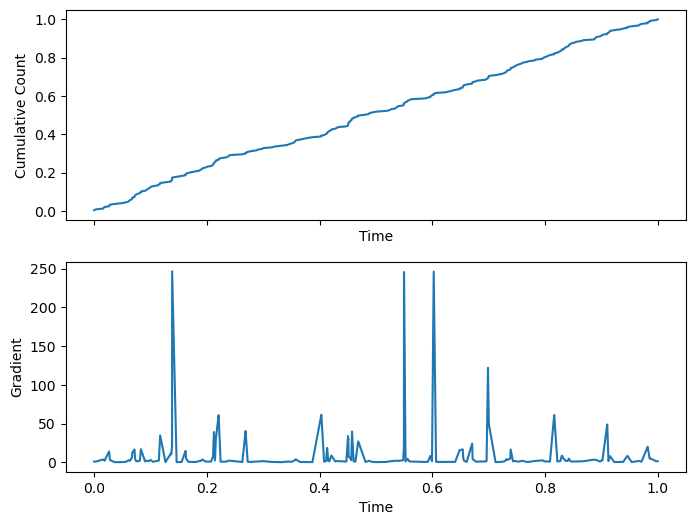

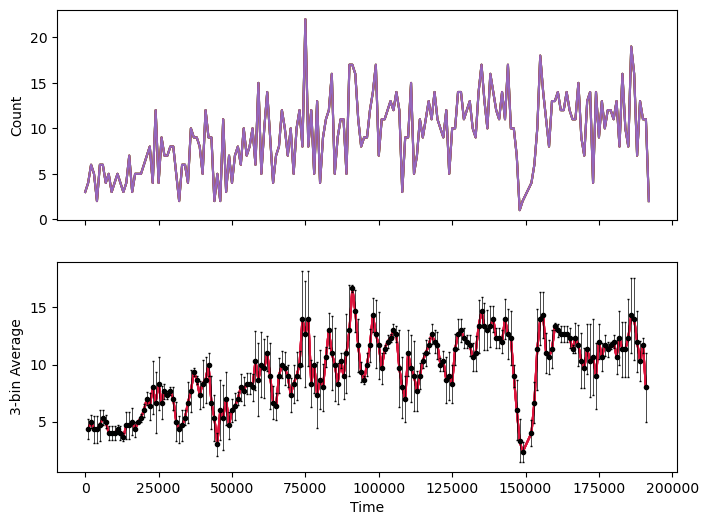

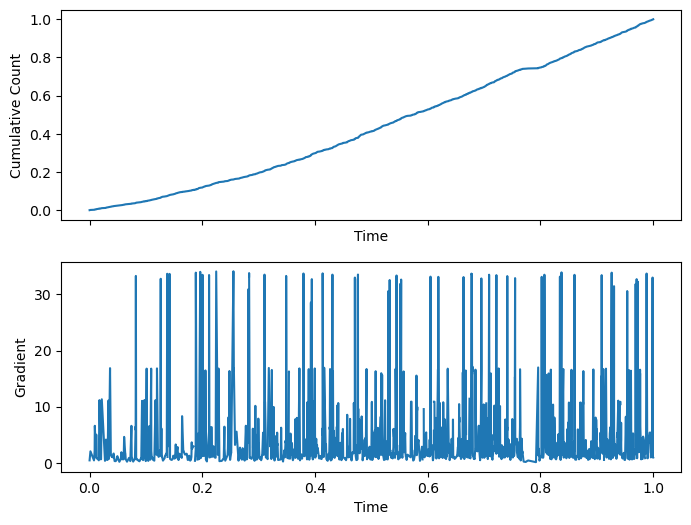

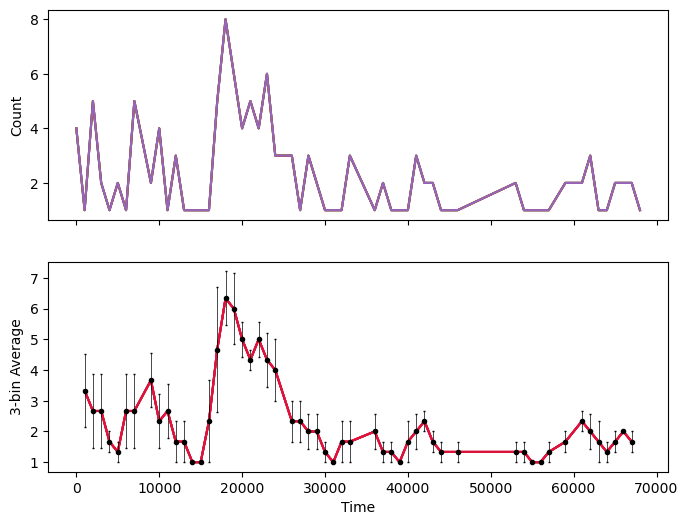

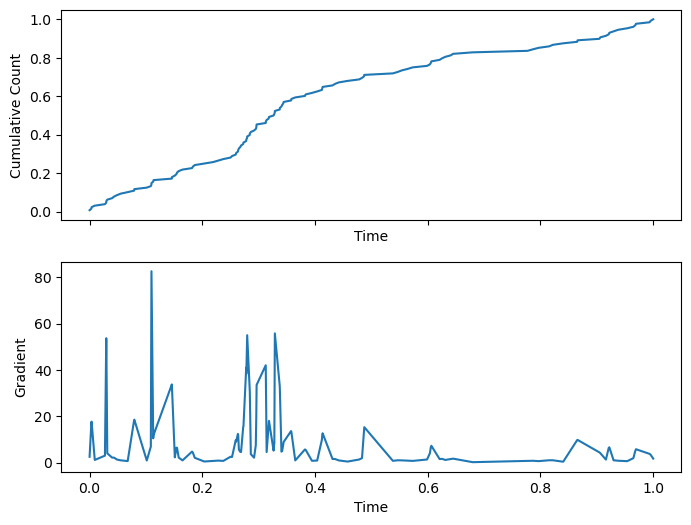

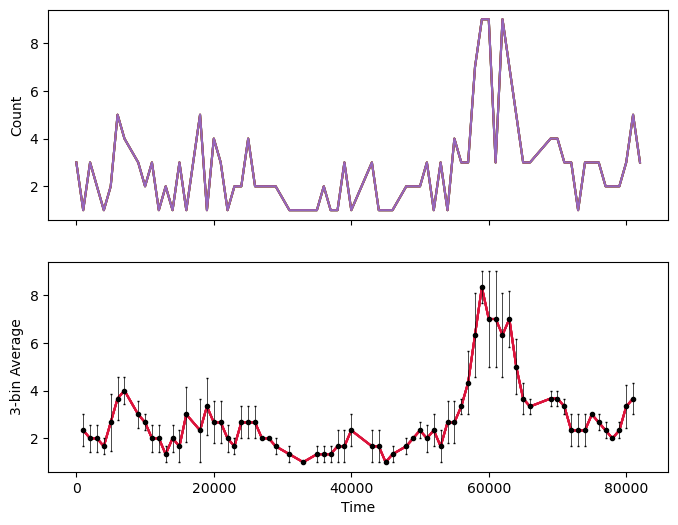

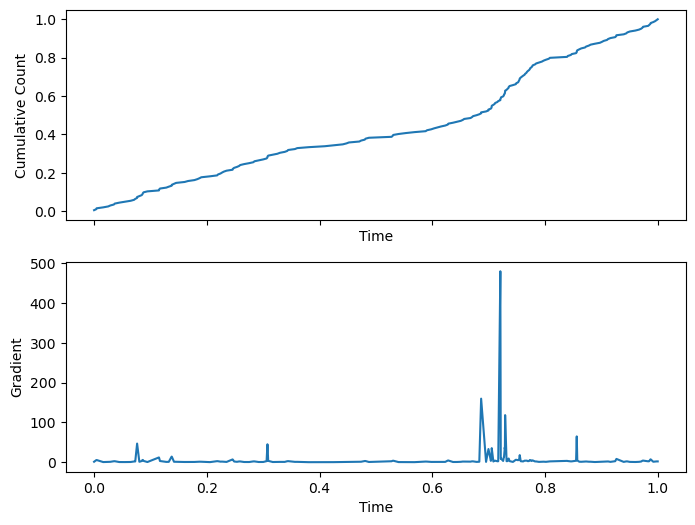

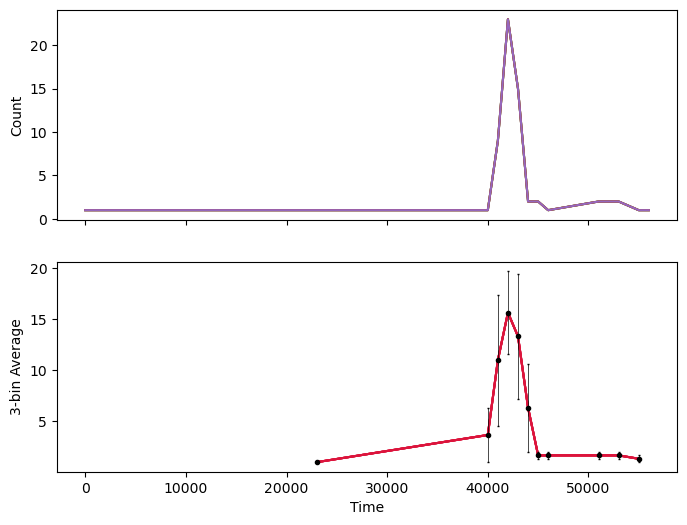

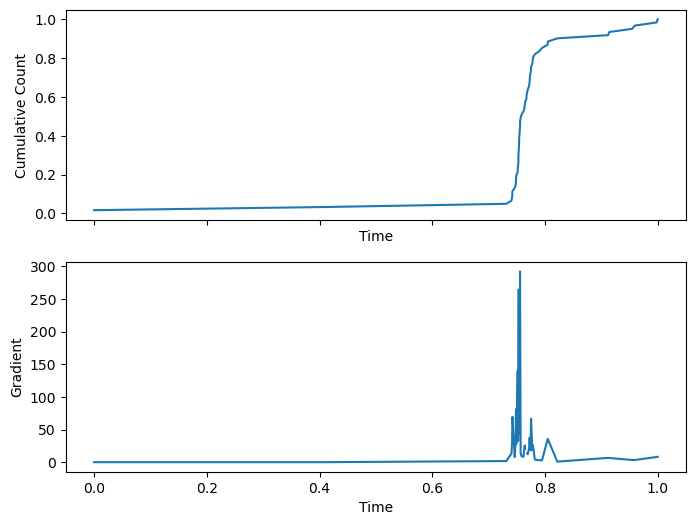

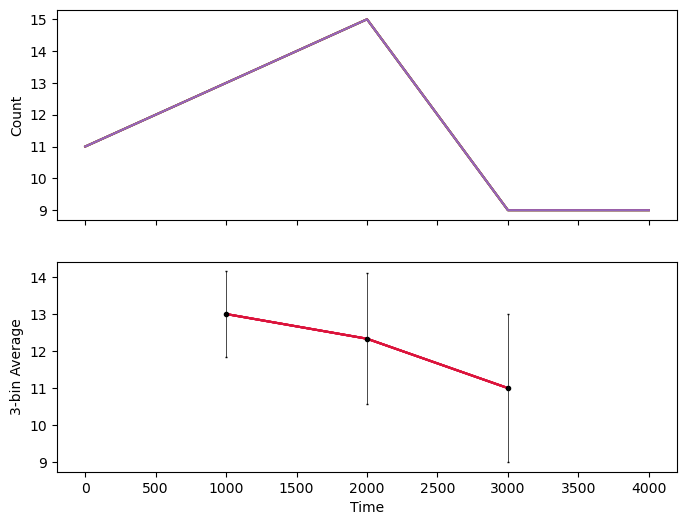

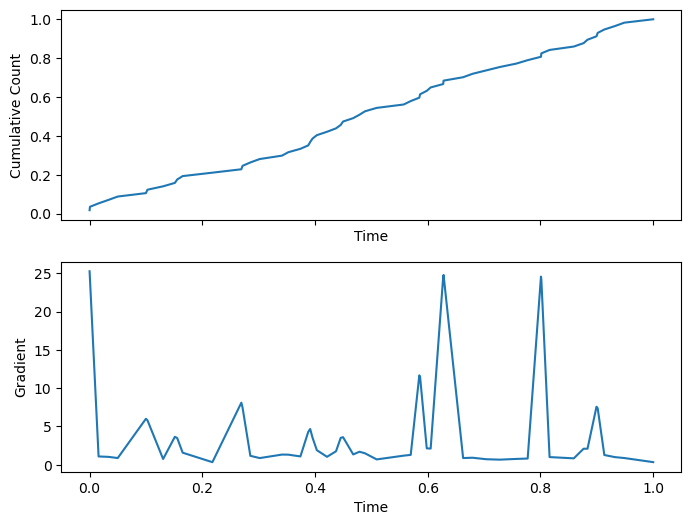

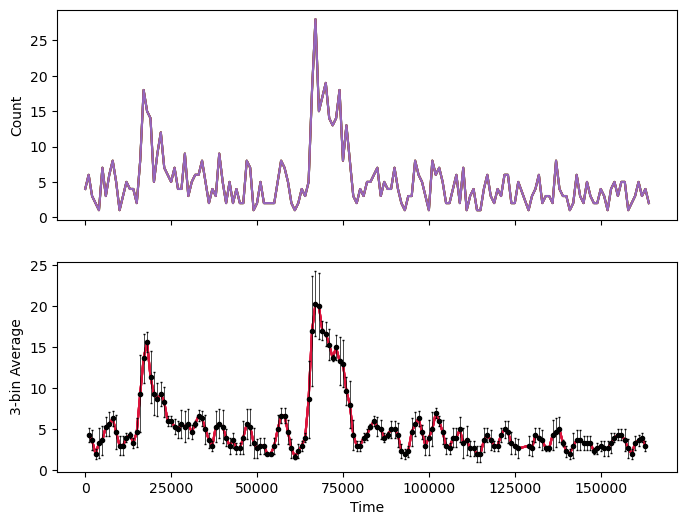

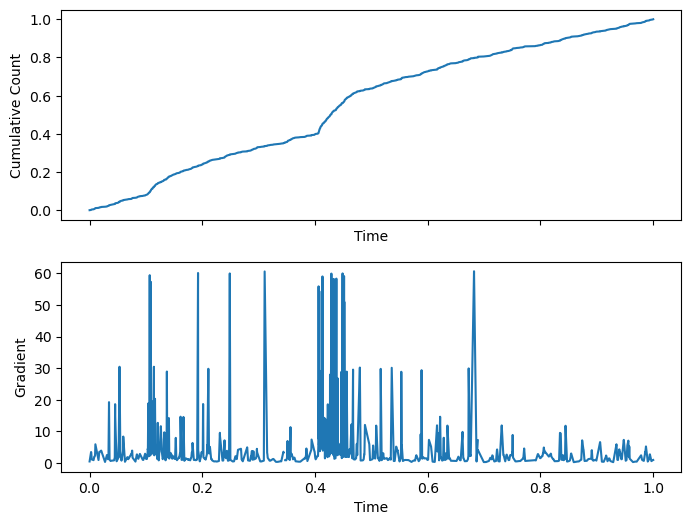

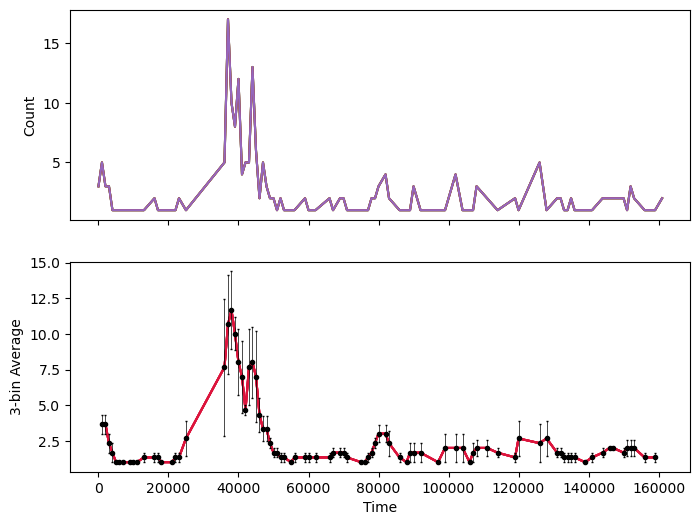

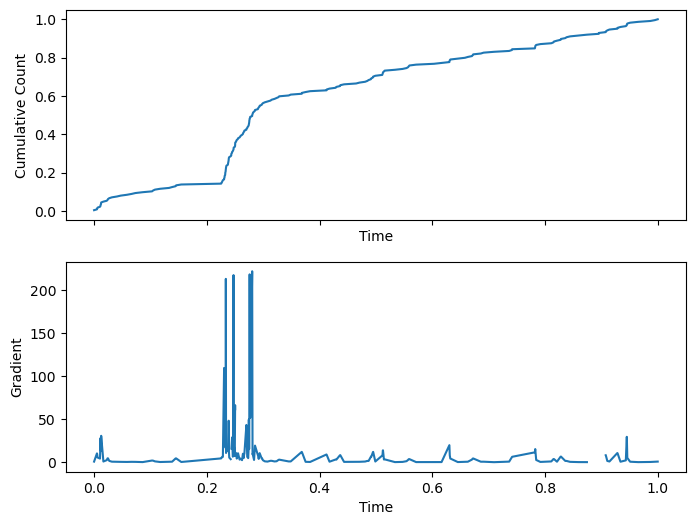

In [49]:
# Loop over all eventfiles
for id_name, dfi in df_eventfiles_group:
    df = dfi.copy()
    df['time'] = dfi['time'] - min(dfi['time'])
    # Bin the data by 1000-second intervals
    df_count = df.groupby(df['time'] // 1000 * 1000).count()
    # Create subplots and plot the binned time series
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    axs[0].plot(df_count.index, df_count)
    axs[0].set_ylabel('Count')

    # Apply rolling 3-bin average and plot the rolling average
    df_rolling = df_count.rolling(window=3, center=True).mean()
    rolling_std = df_count.rolling(window=3, center=True).std()
    axs[1].plot(df_rolling.index, df_rolling,color = "crimson")
    axs[1].set_ylabel('3-bin Average')
    errors = rolling_std['time']/math.sqrt(3)
    axs[1].errorbar(df_rolling.index, df_rolling['time'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)


    # Set x and y labels and show the plot
    plt.xlabel('Time')
    plt.show()

    # Create a cumulative count plot
    df_cumulative = df.copy()
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Normalize the y-axis to range from 0 to 1
    max_time = df_cumulative['time'].max()
    df_cumulative['time_norm'] = df_cumulative['time']/max_time
    max_count = df_cumulative['cumulative_count'].max()
    df_cumulative['cumulative_count_norm'] = df_cumulative['cumulative_count']/max_count
    # Compute the gradient of the normalized cumulative count with respect to time
    df_cumulative['gradient'] = np.gradient(df_cumulative['cumulative_count_norm'], df_cumulative['time_norm'])
    # Plot the normalized cumulative count against time
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    ax[0].plot(df_cumulative['time_norm'], df_cumulative['cumulative_count_norm'])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Cumulative Count')

    ax[1].plot(df_cumulative['time_norm'], df_cumulative['gradient'])
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Gradient')
    
    # Show the plot
    plt.show()

  

In [ ]:
# This is a function that creates some plots of lightcurves! Basically you give it the coords and obsid that you want to look at, and it will produce a cumulative lightcurve, a binned lightcurve, and a running average.
# The argument 

def lc_plot_fun(df_grouped_eventfile, id_name, avg_plot = True, save_png = False):
  """
  DESCRIPTION: Reduces evenfiles table and properties table to required columns and adds unique ID, can now be used for data representation function
  INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
  OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
  """
  # downloads lightcurve and reads important info into a list
  info = pd.read_table(f"./textfiles/{textfile}", " ")
  # info.columns =['TIME_BIN', 'TIME_MIN', 'TIME', 'TIME_MAX',"COUNTS", "STAT_ERR", "AREA", "EXPOSURE", "COUNT_RATE", "COUNT_RATE_ERR"]
  # print(info.shape[0])
  #reset times and drop unecessary columns
  times = df_grouped_eventfile["time"].tolist()
  initial_time = times[0]
  times = [i - initial_time for i in times]
  # list of bins, containing the number of photons in each one
  binned_list = []
  starting_time = 0
  #keeps track of how many photons are in current bin so far
  tally = 0
  current_bin = 0
  for i,row in enumerate(info["COUNTS"]):
    # adds this row's number of photons to the tally
    tally += row
    # checks how many seconds corresponds to this row
    seconds = i*3.24104
    # determines what bin number this should be in then.
    bin_num = int(seconds/(binsize))
    if bin_num - current_bin == 1:
      # if we have just entered a new bin, it adds all the photons received in the previous bin to thatbin
      binned_list.append(tally)
      # resets the tally and moves up one bin
      tally = 0
      current_bin += 1

  number_ahead_and_behind = 1
  # Running Averages
  if avg_True == True:
    avgs = []
    errors = []
    for i in range(0,len(binned_list)):
      # if i < 2:
      #   sum = binned_list[i]+binned_list[i+1]+binned_list[i+2]
      #   avg = sum /3
      #   avgs.append(avg)
      if i >= number_ahead_and_behind and i <= len(binned_list)-number_ahead_and_behind-1:
        list_of_averages = []
        list_of_averages.append(binned_list[i])
        for j in range(1,number_ahead_and_behind+1):
          list_of_averages.append(binned_list[i-j])
          list_of_averages.append(binned_list[i+j])
        summed = sum(list_of_averages)
        avg = summed / (number_ahead_and_behind*2+1)
        std_dev = statistics.stdev(list_of_averages)
        error = std_dev / (math.sqrt(number_ahead_and_behind*2+1))
        errors.append(error)
        avgs.append(avg)
      # if i > len(binned_list)-3:
      #   sum = binned_list[i]+binned_list[i-1]+binned_list[i-2]
      #   avg = sum /3
      #   avgs.append(avg)
      
    # print(avgs)

  # creates a times list for the x-axis in kiloseconds
  bin_times = np.arange(0,times[-1],binsize)
  bin_times = bin_times/1000

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
  plt.rcParams["figure.figsize"] = (15,10)

  # times = [i+ 10000 for i in times]
  # bin_times = [i+ 10 for i in bin_times]

  # creates the graph with appropriate labels
  ax2.step(bin_times[1:], binned_list)
  ax2.set_xlabel("Time [kiloseconds]",fontsize=15)
  ax2.set_title(f"LightCurve with {binsize}s Bin Size",fontsize=15)
  ax2.set_ylabel("Photon Count per Bin",fontsize=15)
  ax2.tick_params(axis='both', which='major', labelsize=20)
  ax2.tick_params(axis='both', which='minor', labelsize=8)
  # ax2.axvline(x = line1, color = 'r', linewidth =.8, linestyle = "dashed")
  # ax2.axvline(x = line2, color = 'r', linewidth =.8, linestyle = "dashed", label = f'Beginning -- {line2}ks')
  # ax2.text(line1 - 2.2,0,line1,rotation=0)
  # ax2.text(line2+ .2 ,0,line2,rotation=0)
  # if avg == True:

  ax3.set_xlabel("Time [kiloseconds]",fontsize=15)
  ax3.set_title(f"Running Average of {number_ahead_and_behind*2+1} bins",fontsize=15)
  ax3.set_ylabel("Photon Count per Bin",fontsize=15)
  ax3.tick_params(axis='both', which='major', labelsize=20)
  ax3.tick_params(axis='both', which='minor', labelsize=8)
  ax3.plot(bin_times[number_ahead_and_behind:len(bin_times)-number_ahead_and_behind-1],avgs, color = "crimson",linewidth=2.5)
  ax3.errorbar(bin_times[number_ahead_and_behind:len(bin_times)-number_ahead_and_behind-1], avgs,
             yerr = errors,
             xerr = None,
             fmt ='.',
             color = "black",
             linewidth = .5,
             capsize = 1)


  # this creates the cumulative graph
  cumu_counts = []
  tot_counts = 0
  for row in info["COUNTS"]:
    tot_counts += row
    cumu_counts.append(tot_counts)



  # plots it
  kilo_times = [i/1000 for i in times]
  ax1.plot(kilo_times, cumu_counts)
  ax1.set_xlabel('Time [kiloseconds]', fontsize=15)
  ax1.set_ylabel('Cumalative Photon Count', fontsize=15)
  ax1.set_title(f"Cumulative Photon Count vs Time", fontsize=15)
  ax1.tick_params(axis='both', which='major', labelsize=20)
  ax1.tick_params(axis='both', which='minor', labelsize=8)


  # makes a filename for easier organization
  parts =textfile.split("_")
  plt.suptitle(f"{parts[0]} ObsID {parts[1]}",fontsize=15)
  plt.figtext(0.5, 0.01, f"Initial Time: {initial_time}", wrap=True, horizontalalignment='center', fontsize=12)
  # print(initial_time)
  # makes easier to read and then saves file
  plt.subplots_adjust(hspace=0.5)
  if save == True:
    plt.savefig(f"{parts[0]}_ObsId_{parts[1]}.png")
    files.download(f"{parts[0]}_ObsId_{parts[1]}.png")